<a href="https://colab.research.google.com/github/pradeepvaranasi/RideSharing_riderAttrition_casestudy/blob/main/RideSharing_Casestudy_EnsembleLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Problem Statement

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

In [1]:
# Imporing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
# Establishing the connection between Colab and Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importing the data from gdrive
data = pd.read_csv('drive/MyDrive/ola_driver_scaler.csv', index_col=False)
data = data.iloc[:,2:]
data.head(2)

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2


Removing the first two columns index (not relevant) and MMM-YY (98% missing values)

In [4]:
df = data.copy()
df.head(2)

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2


In [5]:
df.shape

(19104, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Driver_ID             19104 non-null  int64  
 1   Age                   19043 non-null  float64
 2   Gender                19052 non-null  float64
 3   City                  19104 non-null  object 
 4   Education_Level       19104 non-null  int64  
 5   Income                19104 non-null  int64  
 6   Dateofjoining         19104 non-null  object 
 7   LastWorkingDate       1616 non-null   object 
 8   Joining Designation   19104 non-null  int64  
 9   Grade                 19104 non-null  int64  
 10  Total Business Value  19104 non-null  int64  
 11  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 1.7+ MB


* Missing values found in the following columns:
    1. Age
    2. Gender
    3. LastWorkingDate (Attrition - derive target variable)

* Datatype conversion required for Date Columns


#### Data Preprocessing and Feature Engineering

The data needs to be aggregated at driver_id level as there are multiple records for each driver on monthly basis

In [7]:
df.head()

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [8]:
# Convering the date like features to date datatype

df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])

In [9]:
df.head(5)

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2
1,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2
2,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,2
3,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1
4,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1


In [10]:
# CChecking info for datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver_ID             19104 non-null  int64         
 1   Age                   19043 non-null  float64       
 2   Gender                19052 non-null  float64       
 3   City                  19104 non-null  object        
 4   Education_Level       19104 non-null  int64         
 5   Income                19104 non-null  int64         
 6   Dateofjoining         19104 non-null  datetime64[ns]
 7   LastWorkingDate       1616 non-null   datetime64[ns]
 8   Joining Designation   19104 non-null  int64         
 9   Grade                 19104 non-null  int64         
 10  Total Business Value  19104 non-null  int64         
 11  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(7), object(1)
memory usage: 1.7+ M

In [11]:
# KNN missing value imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)

In [12]:
columns_to_impute = ['Age', 'Gender']
df_num = df[columns_to_impute]

In [13]:
# Fit and transform only the selected num columns
df_num_imputed = pd.DataFrame(imputer.fit_transform(df_num), columns=columns_to_impute)

In [14]:
# Update the original DataFrame with the imputed values
df[columns_to_impute] = df_num_imputed

In [15]:
df.head()

,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2
1,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2
2,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,2
3,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1
4,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1


In [16]:
# Converting gender from float to int datatype
df['Age'] = df['Age'].astype(int)
df['Gender'] = df['Gender'].astype(int)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver_ID             19104 non-null  int64         
 1   Age                   19104 non-null  int64         
 2   Gender                19104 non-null  int64         
 3   City                  19104 non-null  object        
 4   Education_Level       19104 non-null  int64         
 5   Income                19104 non-null  int64         
 6   Dateofjoining         19104 non-null  datetime64[ns]
 7   LastWorkingDate       1616 non-null   datetime64[ns]
 8   Joining Designation   19104 non-null  int64         
 9   Grade                 19104 non-null  int64         
 10  Total Business Value  19104 non-null  int64         
 11  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns](2), int64(9), object(1)
memory usage: 1.7+ MB


In [18]:
# Remove duplicate occurrences of the same driver data
unique_drivers_df = df.drop_duplicates(subset='Driver_ID')

# Group by Driver_ID and aggregate features
grouped_df = unique_drivers_df.groupby('Driver_ID').agg({
    'Age': 'first',
    'Gender': 'first',
    'City': 'first',
    'Education_Level': 'first',
    'Income': 'mean',
    'Dateofjoining': 'first',
    'LastWorkingDate': 'last',
    'Joining Designation': 'first',
    'Grade': 'first',
    'Total Business Value': 'sum',
    'Quarterly Rating': 'last'
})


In [19]:
# Feature Engineering
grouped_df['Rating_Increase'] = grouped_df['Quarterly Rating'].diff().gt(0).astype(int)
grouped_df['Income_Increase'] = grouped_df['Income'].diff().gt(0).astype(int)

In [20]:
# Target variable creation
grouped_df['Target'] = grouped_df['LastWorkingDate'].notnull().astype(int)

In [21]:
# Display the final DataFrame
grouped_df.head()

,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Rating_Increase,Income_Increase,Target
Driver_ID,,,,,,,,,,,,,,
1,28,0,C23,2,57387.0,2018-12-24,NaT,1,1,2381060,2,0,0,0
2,31,0,C7,2,67016.0,2020-11-06,NaT,2,2,0,1,0,1,0
4,43,0,C13,2,65603.0,2019-12-07,NaT,2,2,0,1,0,0,0
5,29,0,C9,0,46368.0,2019-01-09,NaT,1,1,0,1,0,0,0
6,31,1,C11,1,78728.0,2020-07-31,NaT,3,3,0,1,0,1,0


In [22]:
grouped_df.shape

(2381, 14)

In [23]:
# Replacing the last working date with current date
from datetime import datetime
current_date = datetime.now().date()
grouped_df['LastWorkingDate'].fillna(current_date, inplace=True)

In [24]:
grouped_df['LastWorkingDate'] = pd.to_datetime(grouped_df['LastWorkingDate'])

<ipython-input-24-a065942fb871>:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  grouped_df['LastWorkingDate'] = pd.to_datetime(grouped_df['LastWorkingDate'])
<ipython-input-24-a065942fb871>:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  grouped_df['LastWorkingDate'] = pd.to_datetime(grouped_df['LastWorkingDate'])


In [25]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381 entries, 1 to 2788
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Age                   2381 non-null   int64         
 1   Gender                2381 non-null   int64         
 2   City                  2381 non-null   object        
 3   Education_Level       2381 non-null   int64         
 4   Income                2381 non-null   float64       
 5   Dateofjoining         2381 non-null   datetime64[ns]
 6   LastWorkingDate       2381 non-null   datetime64[ns]
 7   Joining Designation   2381 non-null   int64         
 8   Grade                 2381 non-null   int64         
 9   Total Business Value  2381 non-null   int64         
 10  Quarterly Rating      2381 non-null   int64         
 11  Rating_Increase       2381 non-null   int64         
 12  Income_Increase       2381 non-null   int64         
 13  Target            

In [26]:
grouped_df['Experience'] = (grouped_df['LastWorkingDate'] - grouped_df['Dateofjoining']).dt.days

In [27]:
grouped_df.drop(['Dateofjoining', 'LastWorkingDate'], axis=1, inplace=True)

In [29]:
grouped_df.head()

,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Rating_Increase,Income_Increase,Target,Experience
Driver_ID,,,,,,,,,,,,,
1,28,0,C23,2,57387.0,1,1,2381060,2,0,0,0,1803
2,31,0,C7,2,67016.0,2,2,0,1,0,1,0,1120
4,43,0,C13,2,65603.0,2,2,0,1,0,0,0,1455
5,29,0,C9,0,46368.0,1,1,0,1,0,0,0,1787
6,31,1,C11,1,78728.0,3,3,0,1,0,1,0,1218


In [30]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381 entries, 1 to 2788
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   2381 non-null   int64  
 1   Gender                2381 non-null   int64  
 2   City                  2381 non-null   object 
 3   Education_Level       2381 non-null   int64  
 4   Income                2381 non-null   float64
 5   Joining Designation   2381 non-null   int64  
 6   Grade                 2381 non-null   int64  
 7   Total Business Value  2381 non-null   int64  
 8   Quarterly Rating      2381 non-null   int64  
 9   Rating_Increase       2381 non-null   int64  
 10  Income_Increase       2381 non-null   int64  
 11  Target                2381 non-null   int64  
 12  Experience            2381 non-null   int64  
dtypes: float64(1), int64(11), object(1)
memory usage: 260.4+ KB


In [32]:
grouped_df.describe()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Rating_Increase,Income_Increase,Target,Experience
count,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2.381000e+03,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,33.089038,0.410752,1.00756,59209.060899,1.820244,2.078538,2.911751e+05,1.486350,0.239395,0.493910,0.042839,1682.859723
std,5.839201,0.492074,0.81629,28275.899087,0.841433,0.931321,8.117283e+05,0.834348,0.426804,0.500068,0.202537,670.936366
min,21.000000,0.000000,0.00000,10747.000000,1.000000,1.000000,-1.590270e+06,1.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,0.000000,0.00000,39104.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,1277.000000
50%,33.000000,0.000000,1.00000,55276.000000,2.000000,2.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,1543.000000
75%,37.000000,1.000000,2.00000,75765.000000,2.000000,3.000000,2.505900e+05,2.000000,0.000000,1.000000,0.000000,1967.000000
max,58.000000,1.000000,2.00000,188418.000000,5.000000,5.000000,1.039816e+07,4.000000,1.000000,1.000000,1.000000,3896.000000


<ipython-input-40-c6c9e1ebbfa3>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = grouped_df.corr()


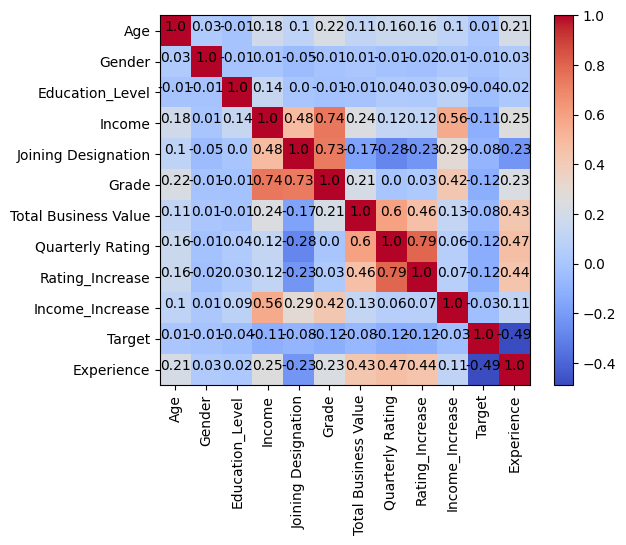

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

#plotting the heatmap for correlation
# Get the correlation matrix
corr = grouped_df.corr()

# Create a heatmap of the correlation matrix
plt.imshow(corr, cmap='coolwarm')
plt.colorbar()

# Add labels for each cell in the heatmap
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(i, j, np.round(corr.iloc[i, j], 2), ha='center')

# Add labels for each row and column

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
# plt.figure(figsize=(14,12))
# Show the heatmap
plt.show()

One-Hot Encoding

In [45]:
grouped_df.head()

,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Rating_Increase,Income_Increase,Target,Experience
Driver_ID,,,,,,,,,,,,,
1,28,0,C23,2,57387.0,1,1,2381060,2,0,0,0,1803
2,31,0,C7,2,67016.0,2,2,0,1,0,1,0,1120
4,43,0,C13,2,65603.0,2,2,0,1,0,0,0,1455
5,29,0,C9,0,46368.0,1,1,0,1,0,0,0,1787
6,31,1,C11,1,78728.0,3,3,0,1,0,1,0,1218


In [46]:
grouped_df.describe()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Rating_Increase,Income_Increase,Target,Experience
count,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2.381000e+03,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,33.089038,0.410752,1.00756,59209.060899,1.820244,2.078538,2.911751e+05,1.486350,0.239395,0.493910,0.042839,1682.859723
std,5.839201,0.492074,0.81629,28275.899087,0.841433,0.931321,8.117283e+05,0.834348,0.426804,0.500068,0.202537,670.936366
min,21.000000,0.000000,0.00000,10747.000000,1.000000,1.000000,-1.590270e+06,1.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,0.000000,0.00000,39104.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,1277.000000
50%,33.000000,0.000000,1.00000,55276.000000,2.000000,2.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,1543.000000
75%,37.000000,1.000000,2.00000,75765.000000,2.000000,3.000000,2.505900e+05,2.000000,0.000000,1.000000,0.000000,1967.000000
max,58.000000,1.000000,2.00000,188418.000000,5.000000,5.000000,1.039816e+07,4.000000,1.000000,1.000000,1.000000,3896.000000


##### One-hot encoding

In [50]:
# Use get_dummies to create one-hot encoding for categorical columns
grouped_df_encoded = pd.get_dummies(grouped_df, columns=['Gender', 'Education_Level', 'Joining Designation', 'Grade',
                                                         'Quarterly Rating', 'Rating_Increase', 'Income_Increase'], drop_first=True)

In [51]:
grouped_df_encoded.head()

,Age,City,Income,Total Business Value,Target,Experience,Gender_1,Education_Level_1,Education_Level_2,Joining Designation_2,...,Joining Designation_5,Grade_2,Grade_3,Grade_4,Grade_5,Quarterly Rating_2,Quarterly Rating_3,Quarterly Rating_4,Rating_Increase_1,Income_Increase_1
Driver_ID,,,,,,,,,,,,,,,,,,,,,
1,28,C23,57387.0,2381060,0,1803,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,31,C7,67016.0,0,0,1120,0,0,1,1,...,0,1,0,0,0,0,0,0,0,1
4,43,C13,65603.0,0,0,1455,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
5,29,C9,46368.0,0,0,1787,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,31,C11,78728.0,0,0,1218,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1


##### Label encoding

In [55]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Label encode categorical columns
grouped_df_encoded['City'] = label_encoder.fit_transform(grouped_df_encoded['City'])


In [56]:
grouped_df_encoded.head()

,Age,City,Income,Total Business Value,Target,Experience,Gender_1,Education_Level_1,Education_Level_2,Joining Designation_2,...,Joining Designation_5,Grade_2,Grade_3,Grade_4,Grade_5,Quarterly Rating_2,Quarterly Rating_3,Quarterly Rating_4,Rating_Increase_1,Income_Increase_1
Driver_ID,,,,,,,,,,,,,,,,,,,,,
1,28,15,57387.0,2381060,0,1803,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,31,26,67016.0,0,0,1120,0,0,1,1,...,0,1,0,0,0,0,0,0,0,1
4,43,4,65603.0,0,0,1455,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
5,29,28,46368.0,0,0,1787,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,31,2,78728.0,0,0,1218,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1


Observations:
1. Grade and Income have a strong positive correlation
2. Total Business Value and Rating show a decent positive correlation
3. Rest of the correlations are derived from respective columns

#### Treating Imbalance Dataset

In [52]:
round(grouped_df_encoded.Target.value_counts(normalize=True)*100,2)

0    95.72
1     4.28
Name: Target, dtype: float64

Dataset is heavily imbalanced with attrition at ~4%

In [53]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [57]:
# Separate features and target variable
X = grouped_df_encoded.drop('Target', axis=1)
y = grouped_df_encoded['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the target variable distribution
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Set the desired ratio of minority class (1) to majority class (0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)



In [59]:
# Display the resampled DataFrame
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['Target'] = y_resampled
resampled_df.head()

,Age,City,Income,Total Business Value,Experience,Gender_1,Education_Level_1,Education_Level_2,Joining Designation_2,Joining Designation_3,...,Grade_2,Grade_3,Grade_4,Grade_5,Quarterly Rating_2,Quarterly Rating_3,Quarterly Rating_4,Rating_Increase_1,Income_Increase_1,Target
0,28,1,87872.0,0,1103,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
1,34,12,38619.0,0,1477,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,27,28,53105.0,0,2485,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,29,14,34234.0,0,1471,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,45,14,90484.0,2108200,3053,0,0,0,0,0,...,0,1,0,0,0,0,1,1,1,0


In [61]:
resampled_df.Target.value_counts(normalize=True)

0    0.666667
1    0.333333
Name: Target, dtype: float64

The minority classes are not increased from 4% of 33%, which makes the dataset workable for building machine learning models